In [1]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.4.0'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark
!pip install -q pyspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done


In [2]:
# Import packages
from pyspark.sql import SparkSession
import time
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

# Create a SparkSession
spark = SparkSession.builder\
    .appName("Flights")\
    .config("spark.sql.debug.maxToStringFields", 2000)\
    .config("spark.driver.memory", "8g")\
    .getOrCreate()

# Set the partitions to 4 or 8.
spark.conf.set("spark.sql.shuffle.partitions", 8)

In [29]:
# Import the data
spark.catalog.clearCache()
flights18_df = spark.read.csv("sample_data/data/2018.csv", inferSchema=True, sep=",", header=True)
flights18_df.show()
flights18_df.count()


+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+
|

6616484

In [30]:
# Convert date columns into Month, Day, Weekday
# Add a Delay column based on the DEP_DELAY or ARR_DELAY
from pyspark.sql import functions as f
from pyspark.sql.functions import year, month, dayofmonth, dayofweek

flights_df = flights18_df.withColumn("Month", month(flights18_df['FL_DATE']))\
                         .withColumn("Day", dayofmonth(flights18_df['FL_DATE']))\
                         .withColumn("Weekday", dayofweek(flights18_df['FL_DATE']))\
                         .withColumn("Delay", f.when((f.col("DEP_DELAY") > 0) | (f.col("ARR_DELAY") > 0), 1)\
                                       .otherwise(0))
flights_df.show()
flights_df.count()

+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+-----+---+-------+-----+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|Month|Day|Weekday|Delay|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+-

6616484

In [31]:
# Create a view for easy data manipulation
flights_df.createOrReplaceTempView("flights")

In [32]:
# Get top 5 airlines, 5 Origin and 5 Dest
filter_df = spark.sql("""
SELECT * FROM flights WHERE op_carrier in ("WN", "AA", "DL", "OO", "UA")
AND Origin in ("ATL", "ORD", "DFW", "CLT", "DEN")
AND Dest in ("ATL", "ORD", "DFW", "CLT", "DEN")
""")
filter_df.show()
filter_df.count()

+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----------+-----+---+-------+-----+
|   FL_DATE|OP_CARRIER|OP_CARRIER_FL_NUM|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|CANCELLATION_CODE|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Unnamed: 27|Month|Day|Weekday|Delay|
+----------+----------+-----------------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+-----------------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+-

92204

In [33]:
# Check if CANCELLATION_CODE has any significance of the Delay reasons
spark.sql("""
SELECT DISTINCT CANCELLATION_CODE,
CARRIER_DELAY,
WEATHER_DELAY,
NAS_DELAY,
SECURITY_DELAY,
LATE_AIRCRAFT_DELAY
FROM flights
WHERE CANCELLATION_CODE IS NOT NULL
""").show()

+-----------------+-------------+-------------+---------+--------------+-------------------+
|CANCELLATION_CODE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|
+-----------------+-------------+-------------+---------+--------------+-------------------+
|                B|         null|         null|     null|          null|               null|
|                C|         null|         null|     null|          null|               null|
|                A|         null|         null|     null|          null|               null|
|                D|         null|         null|     null|          null|               null|
+-----------------+-------------+-------------+---------+--------------+-------------------+



In [34]:
# Remove columns which is not going to help in predictions
flights_cleaned_df = filter_df.drop("FL_DATE", "OP_CARRIER_FL_NUM", "CANCELLATION_CODE", "Unnamed: 27")
flights_cleaned_df.show()
flights_cleaned_df.count()

+----------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----+---+-------+-----+
|OP_CARRIER|ORIGIN|DEST|CRS_DEP_TIME|DEP_TIME|DEP_DELAY|TAXI_OUT|WHEELS_OFF|WHEELS_ON|TAXI_IN|CRS_ARR_TIME|ARR_TIME|ARR_DELAY|CANCELLED|DIVERTED|CRS_ELAPSED_TIME|ACTUAL_ELAPSED_TIME|AIR_TIME|DISTANCE|CARRIER_DELAY|WEATHER_DELAY|NAS_DELAY|SECURITY_DELAY|LATE_AIRCRAFT_DELAY|Month|Day|Weekday|Delay|
+----------+------+----+------------+--------+---------+--------+----------+---------+-------+------------+--------+---------+---------+--------+----------------+-------------------+--------+--------+-------------+-------------+---------+--------------+-------------------+-----+---+-------+-----+
|        UA|   DEN| ORD|         915|   909.0|     -6.0|    12.0|     921.0|   1216.0|   19.0|        1242

92204

In [35]:
# Conver to Pandas DataFrame
pflights_df = flights_cleaned_df.toPandas()
pflights_df.head()

,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,...,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Month,Day,Weekday,Delay
0,UA,DEN,ORD,915,909.0,-6.0,12.0,921.0,1216.0,19.0,...,888.0,NaN,NaN,NaN,NaN,NaN,1,1,2,0
1,UA,ORD,CLT,2101,2127.0,26.0,16.0,2143.0,2359.0,4.0,...,599.0,NaN,NaN,NaN,NaN,NaN,1,1,2,1
2,UA,ORD,DEN,1345,1342.0,-3.0,18.0,1400.0,1511.0,8.0,...,888.0,NaN,NaN,NaN,NaN,NaN,1,1,2,0
3,UA,ORD,DEN,2245,2246.0,1.0,18.0,2304.0,6.0,6.0,...,888.0,NaN,NaN,NaN,NaN,NaN,1,1,2,1
4,UA,DFW,DEN,915,907.0,-8.0,13.0,920.0,955.0,16.0,...,641.0,NaN,NaN,NaN,NaN,NaN,1,1,2,0


In [36]:
# Replace NaN with zeros
pflights_df = pflights_df.fillna(0)
pflights_df.head()

,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,...,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Month,Day,Weekday,Delay
0,UA,DEN,ORD,915,909.0,-6.0,12.0,921.0,1216.0,19.0,...,888.0,0.0,0.0,0.0,0.0,0.0,1,1,2,0
1,UA,ORD,CLT,2101,2127.0,26.0,16.0,2143.0,2359.0,4.0,...,599.0,0.0,0.0,0.0,0.0,0.0,1,1,2,1
2,UA,ORD,DEN,1345,1342.0,-3.0,18.0,1400.0,1511.0,8.0,...,888.0,0.0,0.0,0.0,0.0,0.0,1,1,2,0
3,UA,ORD,DEN,2245,2246.0,1.0,18.0,2304.0,6.0,6.0,...,888.0,0.0,0.0,0.0,0.0,0.0,1,1,2,1
4,UA,DFW,DEN,915,907.0,-8.0,13.0,920.0,955.0,16.0,...,641.0,0.0,0.0,0.0,0.0,0.0,1,1,2,0


In [37]:
# See unique values from all columns
pflights_df.nunique()

OP_CARRIER                5
ORIGIN                    5
DEST                      5
CRS_DEP_TIME            904
DEP_TIME               1288
DEP_DELAY               509
TAXI_OUT                151
WHEELS_OFF             1294
WHEELS_ON              1359
TAXI_IN                 112
CRS_ARR_TIME           1085
ARR_TIME               1358
ARR_DELAY               532
CANCELLED                 2
DIVERTED                  2
CRS_ELAPSED_TIME        161
ACTUAL_ELAPSED_TIME     260
AIR_TIME                216
DISTANCE                 11
CARRIER_DELAY           353
WEATHER_DELAY           215
NAS_DELAY               277
SECURITY_DELAY           26
LATE_AIRCRAFT_DELAY     336
Month                    11
Day                      31
Weekday                   7
Delay                     2
dtype: int64

In [38]:
# Choose y and show
y = pflights_df["Delay"]
y.head()

0    0
1    1
2    0
3    1
4    0
Name: Delay, dtype: int32

In [39]:
# Choose X and show
X = pflights_df.drop(columns="Delay")
X.head()

,OP_CARRIER,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,...,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Month,Day,Weekday
0,UA,DEN,ORD,915,909.0,-6.0,12.0,921.0,1216.0,19.0,...,115.0,888.0,0.0,0.0,0.0,0.0,0.0,1,1,2
1,UA,ORD,CLT,2101,2127.0,26.0,16.0,2143.0,2359.0,4.0,...,76.0,599.0,0.0,0.0,0.0,0.0,0.0,1,1,2
2,UA,ORD,DEN,1345,1342.0,-3.0,18.0,1400.0,1511.0,8.0,...,131.0,888.0,0.0,0.0,0.0,0.0,0.0,1,1,2
3,UA,ORD,DEN,2245,2246.0,1.0,18.0,2304.0,6.0,6.0,...,122.0,888.0,0.0,0.0,0.0,0.0,0.0,1,1,2
4,UA,DFW,DEN,915,907.0,-8.0,13.0,920.0,955.0,16.0,...,95.0,641.0,0.0,0.0,0.0,0.0,0.0,1,1,2


In [40]:
# Convert Non-numeric values using get_dummies
X = pd.get_dummies(X)
X.head()

,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,...,ORIGIN_ATL,ORIGIN_CLT,ORIGIN_DEN,ORIGIN_DFW,ORIGIN_ORD,DEST_ATL,DEST_CLT,DEST_DEN,DEST_DFW,DEST_ORD
0,915,909.0,-6.0,12.0,921.0,1216.0,19.0,1242,1235.0,-7.0,...,0,0,1,0,0,0,0,0,0,1
1,2101,2127.0,26.0,16.0,2143.0,2359.0,4.0,3,3.0,0.0,...,0,0,0,0,1,0,1,0,0,0
2,1345,1342.0,-3.0,18.0,1400.0,1511.0,8.0,1527,1519.0,-8.0,...,0,0,0,0,1,0,0,1,0,0
3,2245,2246.0,1.0,18.0,2304.0,6.0,6.0,30,12.0,-18.0,...,0,0,0,0,1,0,0,1,0,0
4,915,907.0,-8.0,13.0,920.0,955.0,16.0,1025,1011.0,-14.0,...,0,0,0,1,0,0,0,1,0,0


In [41]:
# Split the dataset using train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.2)

In [42]:
# Instantiate a StandardScaler instance
scaler = StandardScaler()

# Fit the training data to the standard scaler
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler
X_test_scaled = X_scaler.transform(X_test)

In [43]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='newton-cholesky', random_state=1)
classifier

LogisticRegression(random_state=1, solver='newton-cholesky')

In [44]:
# Train the data
classifier.fit(X_train_scaled, y_train)

LogisticRegression(random_state=1, solver='newton-cholesky')

In [45]:
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.8611770128655288
Testing Data Score: 0.861233121848056


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [46]:
predictions = classifier.predict(X_test)
pd.DataFrame({"Prediction": predictions, "Actual": y_test})

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


,Prediction,Actual
48227,0,0
77318,1,1
74579,0,0
18937,0,0
90031,0,0
...,...,...
44253,0,0
12303,0,1
18482,1,1
57519,1,0


In [47]:
from sklearn.metrics import accuracy_score
# Display the accuracy score for the test dataset.
accuracy_score(y_test, predictions)

0.861233121848056

In [48]:
# Create a random forest classifier
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [49]:
 # Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [50]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [51]:
 # Calculating the confusion matrix
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [52]:
 # Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,9632,0
Actual 1,0,8809


Accuracy Score : 1.0
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9632
           1       1.00      1.00      1.00      8809

    accuracy                           1.00     18441
   macro avg       1.00      1.00      1.00     18441
weighted avg       1.00      1.00      1.00     18441



In [27]:
 # Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.19267957788840742, 'ACTUAL_ELAPSED_TIME'),
 (0.12731915543562583, 'AIR_TIME'),
 (0.1266045927299553, 'CRS_ELAPSED_TIME'),
 (0.11444910188284087, 'Day'),
 (0.09379062378353871, 'NAS_DELAY'),
 (0.08344891856835342, 'CARRIER_DELAY'),
 (0.06761680786767062, 'Month'),
 (0.0658050002267444, 'Weekday'),
 (0.06351003845779643, 'LATE_AIRCRAFT_DELAY'),
 (0.011670700387051992, 'DISTANCE'),
 (0.011359669031837234, 'WEATHER_DELAY'),
 (0.004986896850693339, 'OP_CARRIER_AA'),
 (0.004724361852765387, 'OP_CARRIER_UA'),
 (0.0029619685690321, 'OP_CARRIER_DL'),
 (0.00292693682401074, 'ORIGIN_ATL'),
 (0.0029018274970867247, 'DEST_ORD'),
 (0.0024469324509415456, 'ORIGIN_DFW'),
 (0.0023795109947146085, 'ORIGIN_ORD'),
 (0.0022738025289448607, 'CANCELLED'),
 (0.0021711998517526176, 'DEST_ATL'),
 (0.002032513776613999, 'ORIGIN_DEN'),
 (0.0020275142226673635, 'DEST_DFW'),
 (0.002015161304183475, 'ORIGIN_CLT'),
 (0.0019153730083391793, 'DEST_DEN'),
 (0.0018858985906928828, 'OP_CARRIER_OO'),
 (0.00178312658908

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

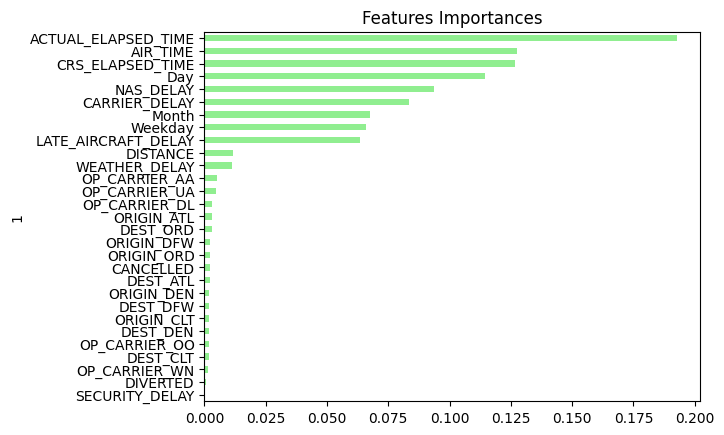

In [28]:
 # Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)